## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [18]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from tinnsleep.config import Config
from tinnsleep.reports import reporting, generate_MEMA_report, preprocess
from tinnsleep.data import RawToEpochs_sliding, CreateRaw
from tinnsleep.utils import merge_labels_list

print("config loaded")


config loaded


In [19]:
#Setting parameters
EDF_list = Config.bruxisme_files
THR_classif=[[0,3], [0,3.5], [0,4]]
window_length = 1                       # in seconds (all epoch duration will be computed from here, might not be exactly this value because of rounding)
duration_factor_OMA = 1                 # how many time window_length
n_adaptive = -60                        # number of seconds for adaptive (negative for forward-backward adaptive scheme)
delim = 3                               # maximal time interval between bursts to merge episode in seconds

# Dictionnary of known names of the Airflow
mapping = {"Airflow": "MEMA"}
print("parameters set")

mema_files = pd.read_csv("data/mema_files.csv",engine='python', sep="; ")["files_with_mema"].values
print(mema_files[:3])

parameters set
['1DA15_nuit_son.edf' '1GB19_nuit_hab.edf' '1MF19_nuit_hab.edf']


## Processing of the dataset and report generation

In [20]:
import warnings
from time import time

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    print("Files processed: ")
    start = time()
    for filename in EDF_list:
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        if file in mema_files:
            #Get channels MEMA
            raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
            raw.rename_channels(mapping=mapping)
            picks_chan_user= ['MEMA']  # could be remplaced by an user-specific list loaded from .pk
            ch_types = "misc"
            #check if channels exists
            picks_chan = [];[picks_chan.append(ch) for ch in picks_chan_user if ch in raw.info["ch_names"]]
            #Get channel names from indexes
            if len(picks_chan)>0: #ignore file if no channel is good
                #----------------- Prepare parameters -----------------------------------------------
                duration = int(window_length * raw.info['sfreq'])  # in sample
                window_length = duration / raw.info['sfreq'] # recompute exact window_length
                duration_OMA = duration_factor_OMA * duration
                n_adaptive = int(n_adaptive/window_length)
            
                #----------------- MEMA processing ---------------------------------------------------
                print("preprocess...", end="");tmp = time()
                epochs, valid_labels, log = preprocess(raw.copy(), duration, interval, picks_chan=['MEMA'])
                valid_labels = [valid_labels]
                
                #----------------- Finding artifacts in other channels (can be stacked) --------------
                # 1. OMA
                valid_labels.append(preprocess(raw, duration_OMA, interval_OMA,
                                        picks_chan=["Activity"],
                                        Thresholding_kwargs=dict(abs_threshold=0, rel_threshold=3, decision_function=lambda foo: np.any(foo>0, axis=-1)),
                                        burst_to_episode_kwargs = dict(min_burst_joining=0, delim=3)
                                        )[1])
                
                #----------------- Merging artifacts labels ------------------------------------------
                resampling_factors = [int(len(epochs)/len(i)) for i in valid_labels]  # compute all resampling factors
                min_labels = min([len(i)*j for (i, j) in zip(valid_labels, resampling_factors)])  # find the common denominator
                assert (len(epochs) - min_labels) < max(resampling_factors), f"shift of {len(epochs) - min_labels} epochs, please check that all duration are proportional"
                epochs = epochs[:min_labels]  # crop last epochs
                valid_labels = [i[:int(min_labels/j)] for (i, j) in zip(valid_labels, resampling_factors)]  # crop valid_labels
                assert len(epochs) == min_labels, f"something went wrong when cropping"
                # print(f"resampling_factors: {resampling_factors}, min_label {min_labels}, final {[len(i) for i in valid_labels]}")
                valid_labels = merge_labels_list(valid_labels, len(epochs))
                print(f"DONE ({time()-tmp:.2f}s)", end=" ")
                
                #----------------- MEMA reporting ----------------------------------------------------
                if np.sum(valid_labels)>0 :
                    print("report...", end="");tmp = time()
                    results[filename] = reporting(epochs, valid_labels, THR_classif, time_interval=window_length, delim=delim, n_adaptive=n_adaptive, generate_report=generate_MEMA_report)
                    print(f"DONE ({time()-tmp:.2f}s)")
                else:
                    print(f"INVALID ({time()-tmp:.2f}s)")
            else:
                print(f"NO VALID CHANNEL")
        else:
            print(f"not included")


print(f"Reports created, process finished in {(time()-start)/60:.1f} min")

Files processed: 
1BA07_nuit_hab.edf not included
1BA07_nuit_son.edf not included
1CC05_nuit_hab.edf not included
1CC05_nuit_son.edf not included
1DA15_nuit_hab.edf not included
1DA15_nuit_son.edf preprocess...DONE (0.96s) report...DONE (18.50s)
1DL12_nuit_hab.edf not included
1DL12_nuit_son.edf not included
1GB18_nuit_son.edf not included
1GB19_nuit_hab.edf preprocess...DONE (1.01s) report...DONE (17.76s)
1GF14_nuit_hab.edf not included
1GF14_nuit_son.edf not included
1MF19_nuit_hab.edf preprocess...DONE (1.11s) report...DONE (18.36s)
1MF19_nuit_son.edf not included
1MN09_nuit_hab.edf not included
1MN09_nuit_son.edf not included
1PI07_nuit_hab.edf not included
1PI07_nuit_son.edf not included
1PT06_nuit_hab.edf not included
1PT06_nuit_son.edf not included
1RA17_nuit_hab.edf preprocess...DONE (1.48s) report...DONE (19.61s)
1RA17_nuit_son.edf not included
1SA14_nuit_hab.edf not included
1SA14_nuit_son.edf not included
1ZN04_nuit_hab.edf not included
1ZN04_nuit_son.edf not included
HZB_nu

## Saving results

In [21]:
df = pd.DataFrame.from_dict(results)
df.to_pickle("data/reports_and_datas_MEMA.pk")

## Data visualization for the entire cohort for nb MEMA episodes per hour as a function of THR_classif value : 

Text(0, 0.5, 'Nb of episodes per hour')

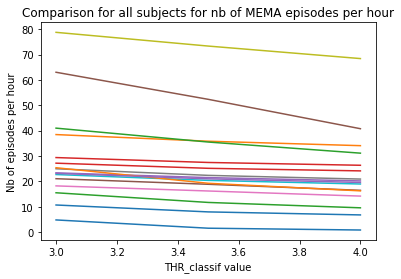

In [22]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    get_r_THRs=[]
    for th in results[elm]["THR_classif"]:
        get_r_THRs.append(th[1])
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of MEMA episodes per hour"])
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean MEMA duration"])
    plt.plot(get_r_THRs, nb_ep)
plt.title('Comparison for all subjects for nb of MEMA episodes per hour')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')


## Data visualization for the entire cohort for nb MEMA bursts as a function of THR_classif value : 

Text(0, 0.5, 'Nb of MEMA burst on the recording')

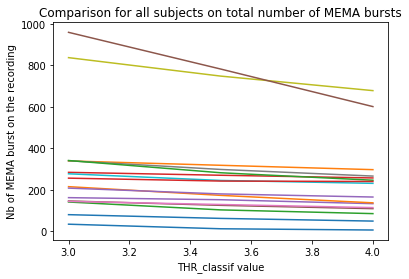

In [23]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    get_r_THRs=[]
    for th in results[elm]["THR_classif"]:
        get_r_THRs.append(th[1])
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of MEMA burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean MEMA duration"])
    plt.plot(get_r_THRs, nb_ep)
plt.title('Comparison for all subjects on total number of MEMA bursts')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of MEMA burst on the recording')


## Extracting list of nb of episodes per hour for all THR_classif per patient

In [24]:
get_scores=[]
for elm in results.keys():
        #print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            l_ep_h.append(ep["Number of MEMA episodes per hour"])

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

16
[['sophie_mema.edf', [27.183998072056873, 25.159657790095192, 24.14748764911435]], ['tom_mema.edf', [23.162158941975456, 21.017514595496248, 19.58775169784344]], ['unger_nuit_1.edf', [63.00558120305933, 52.33928202301385, 40.76345345552264]]]


## Getting masking, VAS-Loudness and  VAS-Intrusiveness data

In [25]:
get_masking = pd.read_csv("data/evol_masquage.csv", delimiter=";")
#print(get_masking)
get_VAS_L = pd.read_csv("data/evol_eva_I.csv", delimiter=";")
#print(get_VAS_L)
get_VAS_I = pd.read_csv("data/evol_eva_G.csv", delimiter=";")
#print(get_VAS_I)

evol_masking = get_masking.values.tolist()[:-4]
evol_VAS_L = get_VAS_L.values.tolist()
evol_VAS_I = get_VAS_I.values.tolist()


## Comparing nb_ep/hour between patients with tinnitus increase (augm) and without (stable) for values of THR_classif

Nb_patients in each group : 
Tinnitus increase : 5
Tinnitus stable : 4


Text(0, 0.5, 'Nb of episodes per hour')

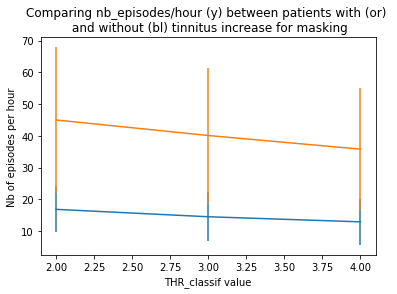

In [26]:
# Files not to consider for analysis
to_suppress=["1MA16_nuit_hab.edf","SCHM_nuit_1.edf","HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for absolute overnight evolutions of tinnitus

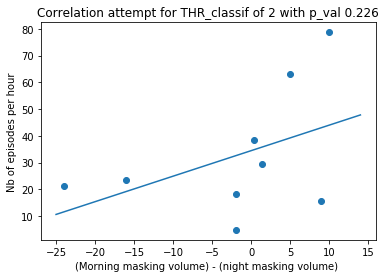

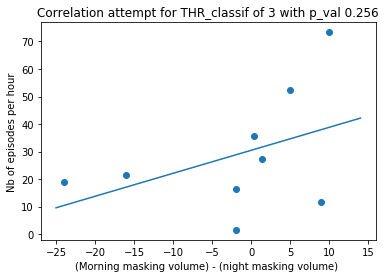

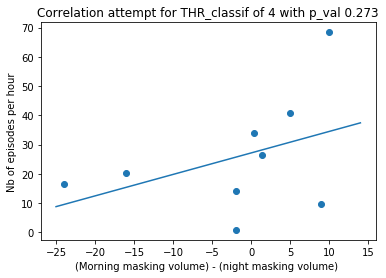

In [27]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for percentage overnight evolutions of tinnitus

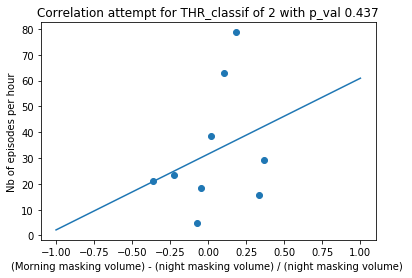

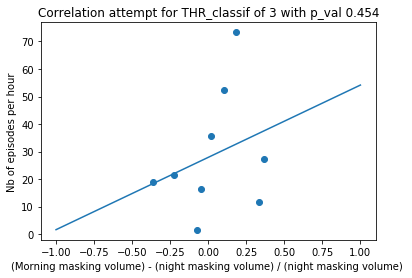

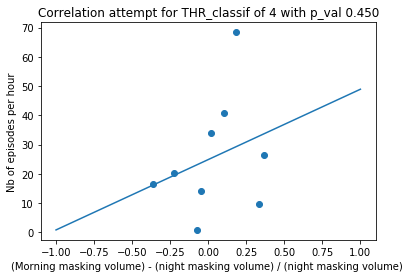

In [28]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## VAS-L

Nb_patients in each group : 
Tinnitus increase : 3
Tinnitus stable : 7


Text(0, 0.5, 'Nb of episodes per hour')

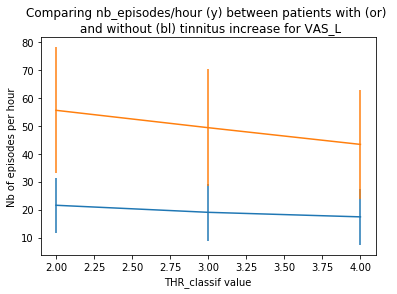

In [29]:
#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_L:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

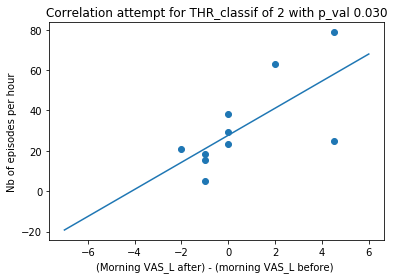

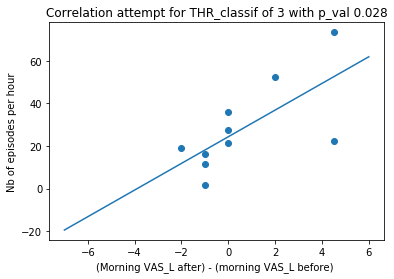

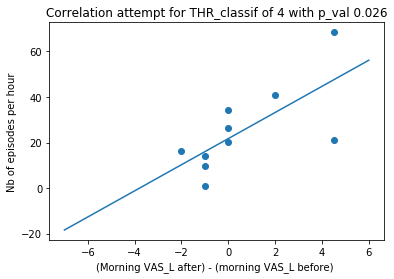

In [30]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

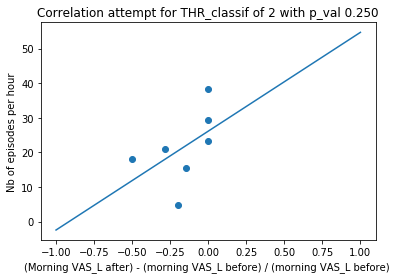

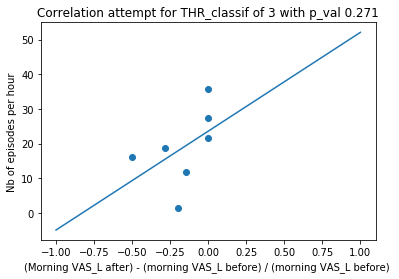

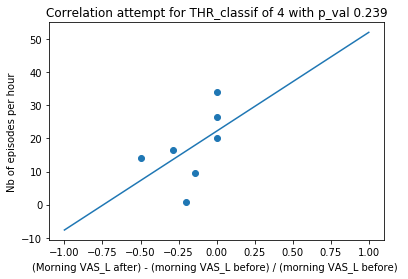

In [31]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) / (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

## VAS_I

Nb_patients in each group : 
Tinnitus increase : 4
Tinnitus stable : 6


Text(0, 0.5, 'Nb of episodes per hour')

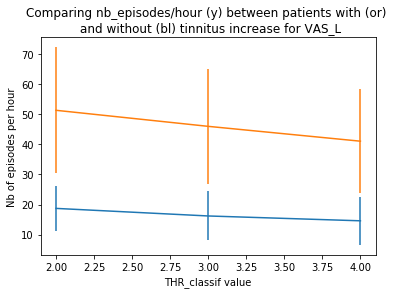

In [32]:
#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_I:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

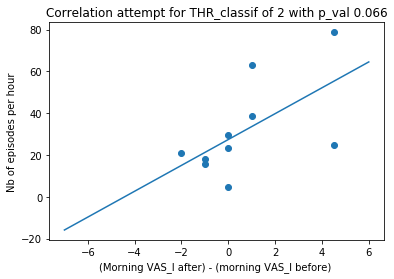

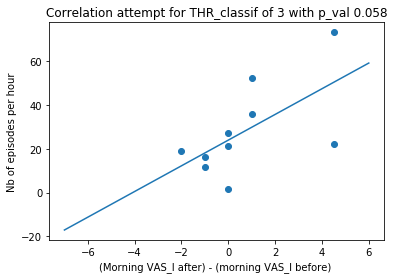

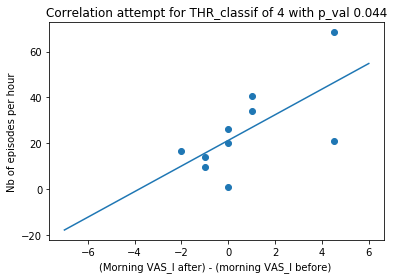

In [33]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

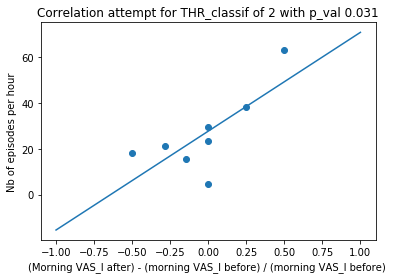

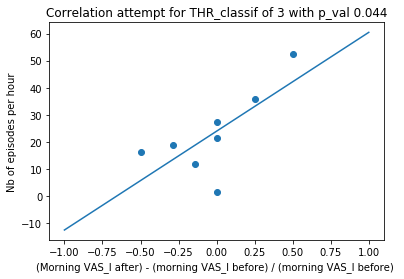

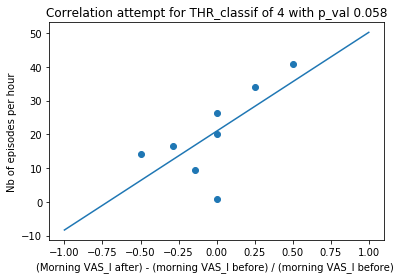

In [34]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) / (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')